In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as trans_f
import torch.nn.functional as nn_f

sys.path.append(os.path.abspath(sys.path[0] + '/../../'))
__package__ = "deep_view_syn.notebook"
torch.cuda.set_device(0)
print("Set CUDA:%d as current device." % torch.cuda.current_device())

from ..data.spherical_view_syn import *
from ..msl_net import MslNet
from ..configs.spherical_view_syn import SphericalViewSynConfig
from ..my import netio
from ..my import util
from ..my import device
from ..my import view
from ..my import color_mode
from ..my import fovea_refine


os.chdir(sys.path[0] + '/../data/sp_view_syn_2020.12.31_fovea')
print('Change working directory to ', os.getcwd())
torch.autograd.set_grad_enabled(False)

Set CUDA:0 as current device.
Change working directory to  /home/dengnc/deep_view_syn/data/sp_view_syn_2020.12.31_fovea


In [2]:
# Load Config
config = SphericalViewSynConfig()
config.from_id('msl_coarse_gray1@msl-gray_e10_fc64x12_d1-20_s16')
config.SAMPLE_PARAMS['spherical'] = True
config.SAMPLE_PARAMS['perturb_sample'] = False
config.print()

# Load Dataset
view_dataset = SphericalViewSynDataset('train.json', load_images=True, load_depths=False, color=color_mode.GRAY)
print('View dataset loaded.')
def read_ref_images(idx):
    patt= 'ref/train/view_%04d.png'
    if isinstance(idx, torch.Tensor) and len(idx.size()) > 0:
        return trans_f.rgb_to_grayscale(util.ReadImageTensor([patt % i for i in idx]))
    else:
        return trans_f.rgb_to_grayscale(util.ReadImageTensor(patt % idx))
print('Ref dataset loaded.')

indices = torch.arange(view_dataset.n_views, device=device.GetDevice()).view(view_dataset.samples)
cam_params = view_dataset.cam_params
lr_cam_params = view.CameraParam({
    "fov" : 10,
    "cx" : 25.0,
    "cy" : 25.0
}, (50, 50)).to(device.GetDevice())
ref_cam_params = view.CameraParam({
    "fx" : 519.615251596838,
    "fy" : -519.615251596838,
    "cx" : 300.0,
    "cy" : 300.0
}, (600, 600)).to(device.GetDevice())
gt_images = view_dataset.view_images
gt_depths = view_dataset.view_depths
rays_o = view_dataset.rays_o
rays_d = view_dataset.rays_d
views_o = view_dataset.view_centers
views_r = view_dataset.view_rots

# Load Spher net
net = MslNet(config.FC_PARAMS, config.SAMPLE_PARAMS, color=color_mode.GRAY, encode_to_dim=config.N_ENCODE_DIM).to(device.GetDevice())
netio.LoadNet('msl_coarse_gray1@msl-gray_e10_fc64x12_d1-20_s16/model-epoch_500.pth', net)
print('Net loaded.')

def plot_point_cloud(pcloud, colors, ax=None):
    if not ax:
        plt.figure(figsize=(12, 12))
        ax = plt.gca(projection='3d')
    points3 = pcloud.flatten(0, -2).cpu().numpy()
    colors = colors.permute(1, 2, 0).flatten(0, 1).expand(-1, 3).cpu().numpy()
    ax.scatter(points3[:, 0], points3[:, 2], points3[:, 1], color=colors, s=0.3)
    util.save_2d_tensor('points.csv', points3)
    util.save_2d_tensor('colors.csv', colors)

==== Config msl_coarse_gray1 ====
Net type:  msl
Encode dim:  10
Full-connected network parameters: {'nf': 64, 'n_layers': 12, 'skips': []}
Sample parameters {'spherical': True, 'depth_range': (1.0, 20.0), 'n_samples': 16, 'perturb_sample': False, 'lindisp': True, 'inverse_r': True}
View dataset loaded.
Ref dataset loaded.
Load net from msl_coarse_gray1@msl-gray_e10_fc64x12_d1-20_s16/model-epoch_500.pth ...
Net loaded.


torch.Size([1, 50, 50]) torch.Size([50, 50])
torch.Size([100, 100, 3]) torch.Size([100, 100, 3]) torch.Size([100, 100])
torch.Size([100, 100, 3]) torch.Size([100, 100, 3]) torch.Size([100, 100]) torch.Size([100, 100, 3])
[100, 100] [4] [4, 100, 100, 3]
torch.Size([4, 100, 100, 3])
torch.Size([4, 100, 100, 3])
torch.Size([100, 100, 3]) torch.Size([100, 100, 3]) torch.Size([100, 100])
torch.Size([100, 100, 3]) torch.Size([100, 100, 3]) torch.Size([100, 100]) torch.Size([100, 100, 3])
[100, 100] [4] [4, 100, 100, 3]
torch.Size([4, 100, 100, 3])
torch.Size([4, 100, 100, 3])


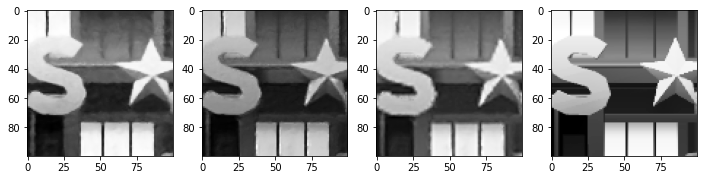

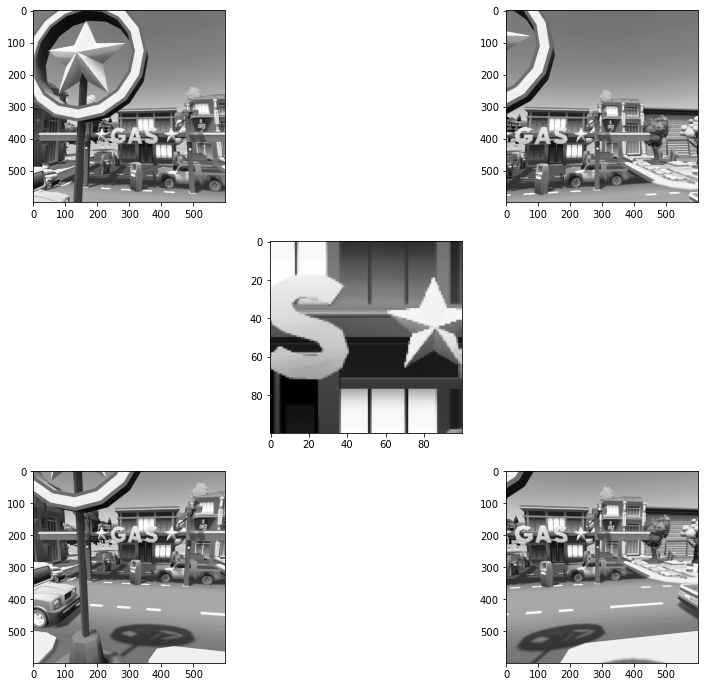

In [4]:
center_view_coord = tuple(val // 2 for val in view_dataset.samples)
center_view_idx = indices[center_view_coord]
bound_view_idxs = [
    indices[center_view_coord[0] - 1, center_view_coord[1] + 1, center_view_coord[2],
            center_view_coord[3] - 1, center_view_coord[4] + 1],
    indices[center_view_coord[0] + 1, center_view_coord[1] + 1, center_view_coord[2],
            center_view_coord[3] + 1, center_view_coord[4] + 1],
    indices[center_view_coord[0] - 1, center_view_coord[1] - 1, center_view_coord[2],
            center_view_coord[3] - 1, center_view_coord[4] - 1],
    indices[center_view_coord[0] + 1, center_view_coord[1] - 1, center_view_coord[2],
            center_view_coord[3] + 1, center_view_coord[4] - 1]
]
# bound_view_idxs = [
#    indices[center_view_coord[0], center_view_coord[1], center_view_coord[2],
#            center_view_coord[3] - 1, center_view_coord[4]],
#    indices[center_view_coord[0], center_view_coord[1], center_view_coord[2],
#            center_view_coord[3] + 1, center_view_coord[4]],
# ]
o = views_o[center_view_idx]
r = views_r[center_view_idx]
center_rays_o = rays_o[center_view_idx]
center_rays_d = rays_d[center_view_idx]
lr_center_rays_o, lr_center_rays_d = lr_cam_params.get_global_rays(
    o, r, flatten=True)

input, depthmap = net(center_rays_o.view(-1, 3), center_rays_d.view(-1, 3), ret_depth=True)
input = input.view(cam_params.res[0], cam_params.res[1], -1).permute(2, 0, 1)
depthmap = depthmap.view(cam_params.res[0], cam_params.res[1])

lr_input, lr_depthmap = net(lr_center_rays_o, lr_center_rays_d, ret_depth=True)
lr_input = lr_input.view(
    lr_cam_params.res[0], lr_cam_params.res[1], -1).permute(2, 0, 1)
lr_depthmap = lr_depthmap.view(lr_cam_params.res[0], lr_cam_params.res[1])
print(lr_input.size(), lr_depthmap.size())

gt = gt_images[center_view_idx]
bounds_img = torch.cat([
    read_ref_images(idx).to(device.GetDevice())
    for idx in bound_view_idxs
], 0)
bounds_o = torch.stack([views_o[idx] for idx in bound_view_idxs], 0)
bounds_r = torch.stack([views_r[idx] for idx in bound_view_idxs], 0)

input_refined = fovea_refine.refine(input, depthmap, center_rays_o, center_rays_d, bounds_img,
                                     bounds_o, bounds_r, ref_cam_params, net, False)
input_refined_lr = fovea_refine.refine(lr_input, lr_depthmap, center_rays_o, center_rays_d,
                                        bounds_img, bounds_o, bounds_r, ref_cam_params, net, True)

#warped = [nn_f.grid_sample(bounds_img[i], bounds_warp[i])
#          for i in range(len(bounds_warp))]
#warped_inferred = [nn_f.grid_sample(
#    bounds_inferred[i], bounds_warp[i]) for i in range(len(bounds_warp))]

fig = plt.figure(figsize=(12, 3))
plt.set_cmap('Greys_r')
plt.subplot(1, 4, 1)
util.PlotImageTensor(input)
plt.subplot(1, 4, 2)
util.PlotImageTensor(input_refined)
plt.subplot(1, 4, 3)
util.PlotImageTensor(input_refined_lr)
plt.subplot(1, 4, 4)
util.PlotImageTensor(gt)
plt.show()


def plot_image_matrices(center_image, ref_images):
    if len(ref_images) == 2:
        plt.figure(figsize=(12, 4))
        plt.set_cmap('Greys_r')
        plt.subplot(1, 3, 1)
        util.PlotImageTensor(ref_images[0])
        plt.subplot(1, 3, 3)
        util.PlotImageTensor(ref_images[1])
        plt.subplot(1, 3, 2)
        util.PlotImageTensor(center_image)
    elif len(ref_images) == 4:
        plt.figure(figsize=(12, 12))
        plt.set_cmap('Greys_r')
        plt.subplot(3, 3, 1)
        util.PlotImageTensor(ref_images[0])
        plt.subplot(3, 3, 3)
        util.PlotImageTensor(ref_images[1])
        plt.subplot(3, 3, 7)
        util.PlotImageTensor(ref_images[2])
        plt.subplot(3, 3, 9)
        util.PlotImageTensor(ref_images[3])
        plt.subplot(3, 3, 5)
        util.PlotImageTensor(center_image)
    plt.show()


#plot_image_matrices(input, warped_inferred)
plot_image_matrices(gt, bounds_img)
#plot_image_matrices(torch.cat(warped[0:3], 1) if len(
#    warped) >= 3 else torch.cat(warped + [torch.zeros_like(warped[0])], 1), warped)
